# ViTDet Evaluation Notebook 

This notebook is dedicated to exploring visiual results of a ViTDet-based on the dataset.  

It covers:
- Loading the trained model configuration and checkpoint  
- Preparing the TCT test dataset for inference  
- Running predictions and extracting bounding boxes  
- Visualizing detection results for selected samples  
- Computing evaluation metrics such as IoU, AP, mAP, and F1-score  

> **Note:** This notebook focuses on visualization and is not a part of training of evaluation pipeline.

In [ ]:
from mask_rcnn_vitdet_b_100ep import load_tct_dataset
from PIL import Image
import numpy as np
import torch
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import matplotlib.pyplot as plt
from detectron2.config import LazyConfig, instantiate

In [ ]:
# 1. Load config
cfg = LazyConfig.load("C:/Users/Asus/Desktop/Cervical-Cancer-Detection/results/vit/output/vitdet_b/config.yaml")
cfg.train.init_checkpoint = "C:/Users/Asus/Desktop/Cervical-Cancer-Detection/results/vit/output/vitdet_b/model_0019999.pth"

# 2. Build and load model
model = instantiate(cfg.model)
model.eval()
checkpointer = torch.load(cfg.train.init_checkpoint, map_location="cpu")
model.load_state_dict(checkpointer["model"])

# 3. Load a sample from your test CSV
dataset_dicts = load_tct_dataset("C:/Users/Asus/Desktop/Cervical-Cancer-Detection/csvfiles/test.csv")
sample = dataset_dicts[1]  # just pick the first image

# 4. Load image using PIL
image_path = sample["file_name"]
image = Image.open(image_path).convert("RGB")
image_np = np.array(image)

# 5. Prepare input for model
inputs = {"image": torch.from_numpy(image_np.transpose(2, 0, 1)).float().to("cpu")}
outputs = model([inputs])[0]

# 6. Visualize ground truth
metadata = MetadataCatalog.get("tct_val")
visualizer_gt = Visualizer(image_np, metadata=metadata)
vis_gt = visualizer_gt.draw_dataset_dict(sample)

# 7. Visualize predictions on top of ground truth
visualizer_pred = Visualizer(vis_gt.get_image(), metadata=metadata)
vis_pred = visualizer_pred.draw_instance_predictions(outputs["instances"].to("cpu"))

# 8. Show the result
plt.figure(figsize=(12, 8))
plt.imshow(vis_pred.get_image())
plt.axis("off")
plt.title("Ground Truth + Prediction")
plt.show()

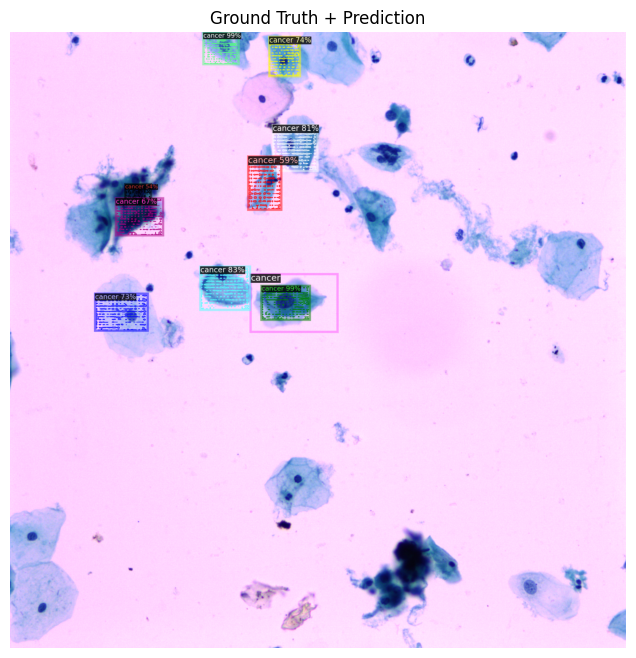


📷 Evaluating image: C:/Users/Asus/Desktop/Cervical-Cancer-Detection/data/JPEGImages/2087307_0288.png

📦 Predicted boxes (x1, y1, x2, y2, score):
  [836.3892211914062, 844.2068481445312, 997.4230346679688, 956.8475952148438]  score=0.9874
  [643.4273681640625, 2.7616233825683594, 759.834716796875, 106.55412292480469]  score=0.9862
  [633.4200439453125, 780.1622314453125, 797.9638671875, 923.906005859375]  score=0.8273
  [873.6593627929688, 308.73736572265625, 1021.5286254882812, 461.95599365234375]  score=0.8098
  [861.5565185546875, 15.8431396484375, 964.447265625, 147.0165557861328]  score=0.7431
  [283.3109436035156, 869.5220947265625, 457.7054138183594, 993.16064453125]  score=0.7317

✅ Evaluation on single image:
  True Positives: 1
  False Positives: 5
  False Negatives: 0
  Precision: 0.1667
  Recall: 1.0000
  F1-score: 0.2857


In [ ]:
from mask_rcnn_vitdet_b_100ep import load_tct_dataset
from PIL import Image
import numpy as np
import torch
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import matplotlib.pyplot as plt
from detectron2.config import LazyConfig, instantiate
from detectron2.structures import Boxes
import torchvision.ops as ops

# 1. Load config
cfg = LazyConfig.load("C:/Users/Asus/Desktop/Cervical-Cancer-Detection/results/vit/output/vitdet_b/config.yaml")
cfg.train.init_checkpoint = "C:/Users/Asus/Desktop/Cervical-Cancer-Detection/results/vit/output/vitdet_b/model_final.pth"
cfg.model.roi_heads.box_predictor.test_score_thresh = 0.5  # ✅ set confidence threshold

# 2. Build and load model
model = instantiate(cfg.model)
model.eval()
checkpointer = torch.load(cfg.train.init_checkpoint, map_location="cpu")
model.load_state_dict(checkpointer["model"])

# 3. Load a sample from your test CSV
dataset_dicts = load_tct_dataset("C:/Users/Asus/Desktop/Cervical-Cancer-Detection/csvfiles/test.csv")
sample = dataset_dicts[1000]

# 4. Load image
image_path = sample["file_name"]
image = Image.open(image_path).convert("RGB")
image_np = np.array(image)

# 5. Prepare model input
inputs = {"image": torch.from_numpy(image_np.transpose(2, 0, 1)).float()}
outputs = model([inputs])[0]
pred_instances = outputs["instances"].to("cpu")

# 6. Visualize ground truth
metadata = MetadataCatalog.get("tct_val")
visualizer_gt = Visualizer(image_np, metadata=metadata)
vis_gt = visualizer_gt.draw_dataset_dict(sample)

# 7. Visualize prediction
visualizer_pred = Visualizer(vis_gt.get_image(), metadata=metadata)
vis_pred = visualizer_pred.draw_instance_predictions(pred_instances)

# 8. Show visualization
plt.figure(figsize=(12, 8))
plt.imshow(vis_pred.get_image())
plt.axis("off")
plt.title("Ground Truth + Prediction")
plt.show()

# --- Show which image is being evaluated ---
print(f"\n📷 Evaluating image: {image_path}")

# --- 9. Evaluate IoU between GT and predictions for AP ---
# Get ground truth boxes
gt_boxes = torch.tensor([anno["bbox"] for anno in sample["annotations"]]).float()
gt_boxes[:, 2] += gt_boxes[:, 0]  # convert [x, y, w, h] -> [x1, y1, x2, y2]
gt_boxes[:, 3] += gt_boxes[:, 1]

# Get predicted boxes & scores
pred_boxes = pred_instances.pred_boxes.tensor
scores = pred_instances.scores

# Filter predictions by threshold
keep = scores >= 0.7
pred_boxes = pred_boxes[keep]
scores = scores[keep]

print("\n📦 Predicted boxes (x1, y1, x2, y2, score):")
for box, score in zip(pred_boxes, scores):
    print(f"  {box.tolist()}  score={score:.4f}")

# Compute IoUs
ious = ops.box_iou(pred_boxes, gt_boxes)

# Match predictions to GT boxes
TP = 0
matched_gt = set()
for i in range(len(pred_boxes)):
    max_iou, max_j = ious[i].max(0)
    if max_iou >= 0.0 and max_j.item() not in matched_gt:
        TP += 1
        matched_gt.add(max_j.item())

FP = len(pred_boxes) - TP
FN = len(gt_boxes) - TP

# Calculate metrics
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"\n✅ Evaluation on single image:")
print(f"  True Positives: {TP}")
print(f"  False Positives: {FP}")
print(f"  False Negatives: {FN}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-score: {f1_score:.4f}")


In [12]:
from detectron2.structures import Boxes, pairwise_iou

pred_box = Boxes(outputs["instances"].pred_boxes.tensor)
gt_box = Boxes(torch.tensor([sample["annotations"][0]["bbox"]], dtype=torch.float32))

# Convert GT box from (x, y, w, h) to (x1, y1, x2, y2)
gt_box.tensor[:, 2] += gt_box.tensor[:, 0]
gt_box.tensor[:, 3] += gt_box.tensor[:, 1]

iou = pairwise_iou(pred_box, gt_box)
print("IoU:", iou)

IoU: tensor([[0.0261],
        [0.0000]], grad_fn=<WhereBackward0>)


# End of the Notebook